## Spatiotemporal Forecasting + Interpolation w/ GPR

Take everything seen so far, and predict P1 and P2 on a regular grid over Berlin at a future timestamp using a spatiotemporal Gaussian Process.

In [1]:
import pandas as pd
import numpy as np
import torch
import gpytorch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


BBOX = {
    "lat_min": 52.3383,
    "lat_max": 52.6755,
    "lon_min": 13.0884,
    "lon_max": 13.7612,
}

### Data ingest

In [ ]:
# ----------------------------
# Hyperparameters
# ----------------------------
LOOKBACK_DAYS = 28         # rolling lookback window in days
TEMP_HORIZON_HOURS = 1     # how far ahead to predict
SPATIAL_TEST_FRAC = 0.2    # fraction of locations held out for spatial test

# ----------------------------
# Read data
# ----------------------------
df = pd.read_parquet("/storage/bln-aq/data/2024-citsci-pollutants-hourly.parquet")

# Ensure datetime
df['timestamp_hour'] = pd.to_datetime(df['timestamp_hour'])

# Aggregate PM2.5 per sensor/location + hour
df = df.groupby(['lat', 'lon', 'timestamp_hour'], as_index=False)['PM2_5'].mean()

# ----------------------------
# Rolling lookback
# ----------------------------
latest_time = df['timestamp_hour'].max()
start_time = latest_time - pd.Timedelta(days=LOOKBACK_DAYS)
df_recent = df[df['timestamp_hour'] >= start_time].copy()

# ----------------------------
# Spatio-temporal train/test split
# ----------------------------

# Select spatial test locations
unique_locations = df_recent[['lat', 'lon']].drop_duplicates()
num_test_locations = int(len(unique_locations) * SPATIAL_TEST_FRAC)
test_locations = unique_locations.sample(n=num_test_locations, random_state=42)

# Temporal split
train_end_time = latest_time - pd.Timedelta(hours=TEMP_HORIZON_HOURS)

# Training set: before temporal horizon AND not in spatial test locations
train_df = df_recent[
    (df_recent['timestamp_hour'] <= train_end_time) &
    (~df_recent.set_index(['lat', 'lon']).index.isin(test_locations.set_index(['lat', 'lon']).index))
].copy()

# Test set: either in spatial test locations OR after temporal horizon
test_df = df_recent[
    (df_recent['timestamp_hour'] > train_end_time) |
    (df_recent.set_index(['lat', 'lon']).index.isin(test_locations.set_index(['lat', 'lon']).index))
].copy()

# ----------------------------
# Convert time to minutes since start (relative to training start)
# ----------------------------
train_start_time = train_df['timestamp_hour'].min()
train_df['minutes_since_start'] = (train_df['timestamp_hour'] - train_start_time).dt.total_seconds() / 60
test_df['minutes_since_start'] = (test_df['timestamp_hour'] - train_start_time).dt.total_seconds() / 60

# ----------------------------
# Features & targets
# ----------------------------
X_train = train_df[['lat','lon','minutes_since_start']].values
y_train = train_df['PM2_5'].values
X_test = test_df[['lat','lon','minutes_since_start']].values
y_test = test_df['PM2_5'].values

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

# ----------------------------
# Device
# ----------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ----------------------------
# Optional: add small constant to avoid log(0)
# ----------------------------
epsilon = 1e-3

# ----------------------------
# Remove outliers first (3 std dev)
# ----------------------------
train_mask = np.abs(y_train - y_train.mean()) < 3 * y_train.std()
test_mask = np.abs(y_test - y_test.mean()) < 3 * y_test.std()

X_train_filtered = X_train[train_mask]
y_train_filtered = y_train[train_mask]
X_test_filtered = X_test[test_mask]
y_test_filtered = y_test[test_mask]

print("Filtered train shape:", X_train_filtered.shape, y_train_filtered.shape)
print("Filtered test shape:", X_test_filtered.shape, y_test_filtered.shape)

# ----------------------------
# Apply log transform to targets
# ----------------------------
y_train_log = np.log1p(y_train_filtered + epsilon)  # log(1 + y + ε)
y_test_log = np.log1p(y_test_filtered + epsilon)

# ----------------------------
# Scale features and log-transformed targets
# ----------------------------
scaler_X = StandardScaler().fit(X_train_filtered)
X_train_scaled = torch.tensor(scaler_X.transform(X_train_filtered), dtype=torch.float32).to(device)
X_test_scaled = torch.tensor(scaler_X.transform(X_test_filtered), dtype=torch.float32).to(device)

scaler_y = StandardScaler().fit(y_train_log.reshape(-1,1))
y_train_scaled = torch.tensor(scaler_y.transform(y_train_log.reshape(-1,1)), dtype=torch.float32).squeeze().to(device)
y_test_scaled = torch.tensor(scaler_y.transform(y_test_log.reshape(-1,1)), dtype=torch.float32).squeeze().to(device)

Train shape: (92811, 3) (92811,)
Test shape: (24232, 3) (24232,)
Filtered train shape: (92092, 3) (92092,)
Filtered test shape: (24087, 3) (24087,)


In [3]:
print("First 5 hours of train set")
for i in range (5):
    print(X_train[i], y_train[i])

First 5 hours of train set
[52.34112525 13.4041644   0.        ] 4.0256
[52.34112525 13.4041644  60.        ] 4.4725
[ 52.34112525  13.4041644  120.        ] 4.0256
[ 52.34112525  13.4041644  180.        ] 3.956666666666667
[ 52.34112525  13.4041644  240.        ] 4.5248


In [4]:
# Inspect outliers - There are none at the 3 sigma threshold
len(X_train_scaled[abs(X_train_scaled) >= 3*X_train_scaled.std(axis=0),])


0

In [5]:
class SpatioTemporalGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(0)
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True
        )
        super().__init__(variational_strategy)

        # Spatial kernel (latitude, longitude)
        spatial_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=2, active_dims=[0, 1])
        )

        # Temporal kernel (minutes since start)
        temporal_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(period_length=24.0, active_dims=[2])
        )

        spatial_kernel.base_kernel.lengthscale = torch.tensor([0.1,0.1])
        temporal_kernel.base_kernel.lengthscale = torch.tensor([1.0])

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = spatial_kernel + temporal_kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Instantiation

In [ ]:
# ----------------------------
# Grid size
# ----------------------------
grid_size = 25  # 10x10 grid = 100 inducing points

# ----------------------------
# Get bounds of training data
# ----------------------------
lat_min, lat_max = X_train[:,0].min(), X_train[:,0].max()
lon_min, lon_max = X_train[:,1].min(), X_train[:,1].max()

# ----------------------------
# Create spatial grid
# ----------------------------
lat_grid = np.linspace(lat_min, lat_max, grid_size)
lon_grid = np.linspace(lon_min, lon_max, grid_size)
lat_mesh, lon_mesh = np.meshgrid(lat_grid, lon_grid)
grid_points = np.column_stack([lat_mesh.ravel(), lon_mesh.ravel()])  # (100,2)

# ----------------------------
# Add temporal dimension
# ----------------------------
time_median = np.median(X_train[:,2])
inducing_points = np.column_stack([grid_points, np.full(grid_points.shape[0], time_median)])  # (100,3)

# ----------------------------
# Scale to match training data
# ----------------------------
inducing_points = torch.tensor(scaler_X.transform(inducing_points), dtype=torch.float32).to(device)

In [7]:

# ----------------------------
# Model + Likelihood
# ----------------------------
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = SpatioTemporalGP(inducing_points).to(device)
likelihood.noise = torch.tensor(1e-2)

# ----------------------------
# Training hyperparameters
# ----------------------------
training_iterations = 5000
learning_rate = 1e-3

# ----------------------------
# Optimizer
# ----------------------------
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()}
], lr=learning_rate)

# ----------------------------
# Loss (ELBO)
# ----------------------------
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=X_train_scaled.size(0))

### Train Loop

In [8]:
# ----------------------------
# Training loop - Need a larger GPU!
# ----------------------------
model.train()
likelihood.train()

train_elbos = []
val_elbos = []

best_val_loss = float('inf')
patience = 50           # stop if no improvement for 50 iterations
trigger_times = 0

for i in range(training_iterations):
    optimizer.zero_grad()
    
    # Forward + ELBO loss
    output = model(X_train_scaled)
    loss = -mll(output, y_train_scaled)
    loss.backward()
    optimizer.step()
    
    # Store training
    train_elbos.append(-loss.item())  # convert to ELBO (higher is better)

    # Evaluate on validation set
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        val_output = model(X_test_scaled)
        val_loss = -mll(val_output, y_test_scaled).item()
    val_elbos.append(-val_loss)  # convert to ELBO
    model.train()



    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        # Optional: save best model parameters
        best_state_dict = model.state_dict()
        best_likelihood_state_dict = likelihood.state_dict()
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at iteration {i+1}")
            break
    
    if (i+1) % 25 == 0 or i == 0:
        print(f"Iter {i+1}/{training_iterations} - Train ELBO: {loss.item():.4f} - Val ELBO: {val_loss:.4f}")

# Load best parameters
model.load_state_dict(best_state_dict)
likelihood.load_state_dict(best_likelihood_state_dict)

Iter 1/5000 - Train ELBO: 117.9320 - Val ELBO: 101.6439
Iter 25/5000 - Train ELBO: 99.2129 - Val ELBO: 86.3006
Iter 50/5000 - Train ELBO: 86.9159 - Val ELBO: 78.1226
Iter 75/5000 - Train ELBO: 76.1284 - Val ELBO: 71.2120
Iter 100/5000 - Train ELBO: 64.3436 - Val ELBO: 63.2853
Iter 125/5000 - Train ELBO: 54.4602 - Val ELBO: 56.6567
Iter 150/5000 - Train ELBO: 47.2501 - Val ELBO: 52.4507
Iter 175/5000 - Train ELBO: 42.5536 - Val ELBO: 50.1991
Iter 200/5000 - Train ELBO: 38.9590 - Val ELBO: 48.5665
Iter 225/5000 - Train ELBO: 36.0312 - Val ELBO: 47.3020
Iter 250/5000 - Train ELBO: 33.5740 - Val ELBO: 46.2747
Iter 275/5000 - Train ELBO: 31.4720 - Val ELBO: 45.5215
Iter 300/5000 - Train ELBO: 29.6422 - Val ELBO: 44.9287
Iter 325/5000 - Train ELBO: 28.0415 - Val ELBO: 44.3968
Iter 350/5000 - Train ELBO: 26.6107 - Val ELBO: 44.0101
Iter 375/5000 - Train ELBO: 25.2902 - Val ELBO: 43.7919


/storage/bln-aq/.venv/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/storage/bln-aq/.venv/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/storage/bln-aq/.venv/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


NotPSDError: Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.

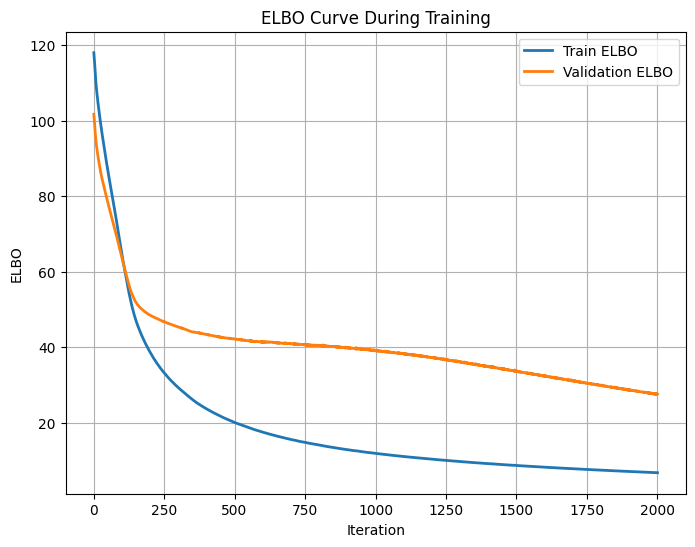

In [ ]:
# ----------------------------
# Plot ELBO curves -- NOTE: YOU WANT HIGH ELBO -> PLOT IS NOT LEGIT!
# ----------------------------
plt.figure(figsize=(8,6))
plt.plot(range(1, len(train_elbos)+1), np.array(train_elbos), label='Train ELBO', lw=2)
plt.plot(range(1, len(val_elbos)+1), np.array(val_elbos), label='Validation ELBO', lw=2)
plt.xlabel('Iteration')
plt.ylabel('ELBO')
plt.title('ELBO Curve During Training')
plt.legend()
plt.grid(True)
plt.show()

Test RMSE: 10.455
Test R²: -2.116


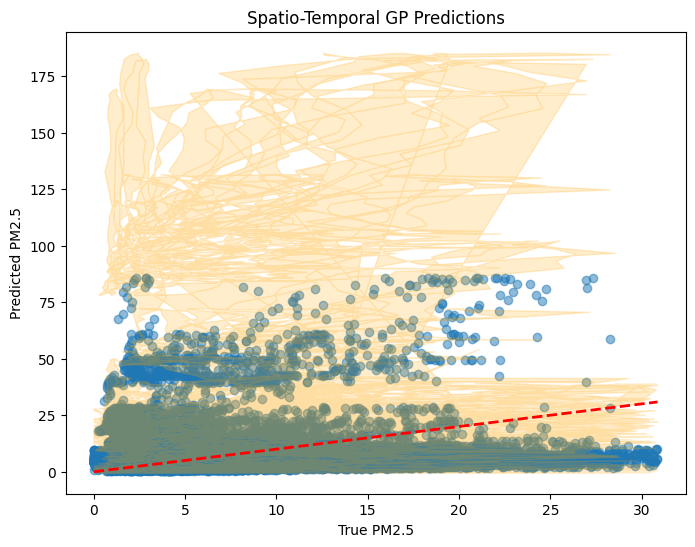

In [ ]:
# ----------------------------
# Evaluation
# ----------------------------
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(X_test_scaled))
    mean_preds = preds.mean
    lower, upper = preds.confidence_region()

# Inverse scale first
mean_preds_scaled_back = scaler_y.inverse_transform(mean_preds.cpu().numpy().reshape(-1,1)).squeeze()
lower_scaled_back = scaler_y.inverse_transform(lower.cpu().numpy().reshape(-1,1)).squeeze()
upper_scaled_back = scaler_y.inverse_transform(upper.cpu().numpy().reshape(-1,1)).squeeze()
y_test_scaled_back = scaler_y.inverse_transform(y_test_scaled.cpu().numpy().reshape(-1,1)).squeeze()

# Then invert log transform
mean_preds_unscaled = np.expm1(mean_preds_scaled_back) - epsilon
lower_unscaled = np.expm1(lower_scaled_back) - epsilon
upper_unscaled = np.expm1(upper_scaled_back) - epsilon
y_test_unscaled = np.expm1(y_test_scaled_back) - epsilon

# ----------------------------
# Metrics
# ----------------------------
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test_unscaled, mean_preds_unscaled))
r2 = r2_score(y_test_unscaled, mean_preds_unscaled)

print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²: {r2:.3f}")

# ----------------------------
# Optional plot
# ----------------------------
plt.figure(figsize=(8,6))
plt.scatter(y_test_unscaled, mean_preds_unscaled, alpha=0.5)
plt.plot([y_test_unscaled.min(), y_test_unscaled.max()],
         [y_test_unscaled.min(), y_test_unscaled.max()],
         'r--', lw=2)
plt.fill_between(y_test_unscaled, lower_unscaled, upper_unscaled, color='orange', alpha=0.2)
plt.xlabel("True PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Spatio-Temporal GP Predictions")
plt.show()

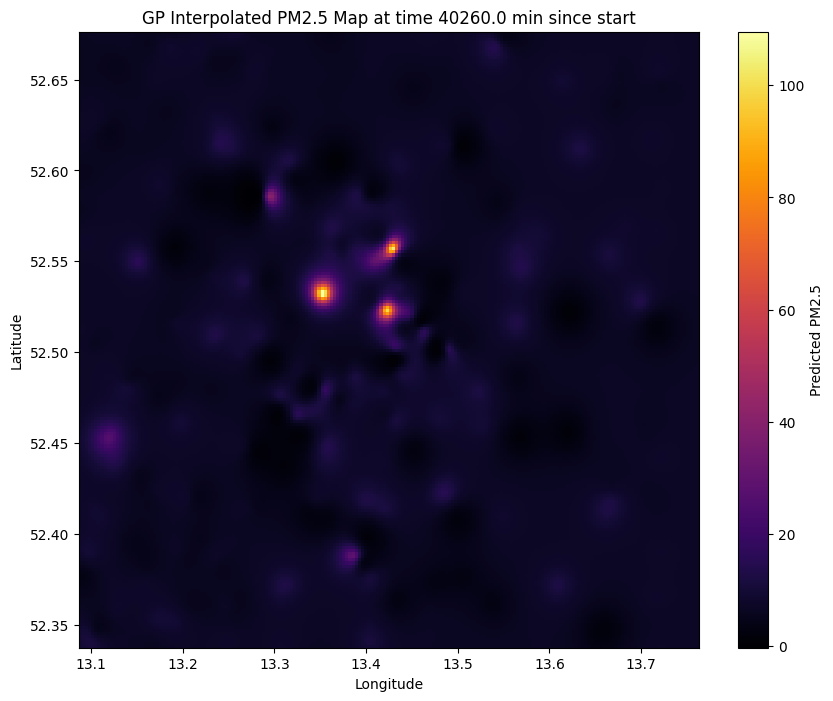

In [ ]:
# Choose the time for the map (e.g., last training timestamp)
map_time = train_df['minutes_since_start'].max()
map_time_tensor = torch.tensor([map_time], dtype=torch.float32).to(device)

# Create a regular grid of lat/lon
grid_lon = np.linspace(BBOX['lon_min'], BBOX['lon_max'], 200)
grid_lat = np.linspace(BBOX['lat_min'], BBOX['lat_max'], 200)
grid_lon_mesh, grid_lat_mesh = np.meshgrid(grid_lon, grid_lat)

# Flatten the grid
grid_coords = np.column_stack([
    grid_lat_mesh.ravel(),
    grid_lon_mesh.ravel(),
    np.full(grid_lat_mesh.size, map_time)  # temporal feature
])

# Scale features
grid_coords_scaled = torch.tensor(scaler_X.transform(grid_coords), dtype=torch.float32).to(device)

# Predict with GP
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred_dist = likelihood(model(grid_coords_scaled))
    mean_pred = pred_dist.mean
    lower, upper = pred_dist.confidence_region()

# Inverse scale first
mean_pred_scaled_back = scaler_y.inverse_transform(mean_pred.cpu().numpy().reshape(-1,1)).squeeze()
lower_scaled_back = scaler_y.inverse_transform(lower.cpu().numpy().reshape(-1,1)).squeeze()
upper_scaled_back = scaler_y.inverse_transform(upper.cpu().numpy().reshape(-1,1)).squeeze()

# Then invert log transform
mean_pred_unscaled = np.expm1(mean_pred_scaled_back) - epsilon
lower_unscaled = np.expm1(lower_scaled_back) - epsilon
upper_unscaled = np.expm1(upper_scaled_back) - epsilon

# Reshape back to grid
mean_grid = mean_pred_unscaled.reshape(grid_lat_mesh.shape)
lower_grid = lower_unscaled.reshape(grid_lat_mesh.shape)
upper_grid = upper_unscaled.reshape(grid_lat_mesh.shape)

# Plot
plt.figure(figsize=(10,8))
plt.pcolormesh(grid_lon_mesh, grid_lat_mesh, mean_grid, cmap='inferno', shading='auto')
plt.colorbar(label='Predicted PM2.5')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'GP Interpolated PM2.5 Map at time {map_time:.1f} min since start')
plt.show()